In [646]:
# Selina 25 Feb 2019
# Program to do exploratory data analysis for SingHealth assessment

# Import relevant modules
import os
import numpy as np
#from sklearn import datasets, linear_model
#from sklearn.metrics import mean_squared_error, r2_score

# Set directories, filenames and url api
dataFolder = os.getcwd()
inputFileName='10kDiabetes.csv'
    # This is my filename with merged data and geodata
input_file=os.path.join(dataFolder,inputFileName)

# Read in data
raw_data=pd.read_csv(input_file)
#raw_data.columns  Have a look at what the columns are and see the unique info
#raw_data.loc[:,'readmitted'].unique()


In [648]:
# Ok, first apply criteria for acceptance of data
# Apply the same criteria as the paper used

# First of all, we only want to look at inpatient encounters 
# with hospitaliztion that lasted 1-14 days
cleaned_data=raw_data.copy()

idx1=cleaned_data.index[cleaned_data['time_in_hospital']>0]
idx2=cleaned_data.index[cleaned_data['time_in_hospital']<=14]
idx=idx1 & idx2
cleaned_data=cleaned_data.loc[idx,:]

# Ok, for our analysis, remove patient data with multiple inpatient encounters
idx=cleaned_data.index[cleaned_data['number_inpatient']==0]
cleaned_data=cleaned_data.loc[idx,:]
#cleaned_data.columns

# Only look at data where patients have been diagnosed with diabetes
idx1=cleaned_data['diag_1_desc'].str.contains('diabetes mellitus',case=False)
idx2=cleaned_data['diag_2_desc'].str.contains('diabetes mellitus',case=False)
idx3=cleaned_data['diag_3_desc'].str.contains('diabetes mellitus',case=False)
idx=idx1 | idx2 | idx3
idx=idx[idx==True]

cleaned_data=cleaned_data.loc[idx.index,:]
#Series.str.contains(pat, case=True, flags=0, na=nan, regex=True)[source]

# Remove data where patient died or was transfered to hospice
idx1=cleaned_data['discharge_disposition_id'].str.contains('expired',case=False)
idx2=cleaned_data['discharge_disposition_id'].str.contains('hospice',case=False)
idx3=cleaned_data['discharge_disposition_id'].apply(pd.isnull)
idx=(idx1 | idx2)
idx=idx[idx==True]
cleaned_data=cleaned_data.drop(index=idx.index)
idx3=idx3[idx3==True]
cleaned_data.loc[idx3.index,'discharge_disposition_id']='NA'
# Also, regroup data into home and other (create new variable)
idx=cleaned_data['discharge_disposition_id'].str.contains('home',case=False)
idx1=idx[idx==True]
cleaned_data.loc[idx1.index,'discharge_home']=idx1
idx2=idx[idx!=True]
cleaned_data.loc[idx2.index,'discharge_home']=idx2
cleaned_data.loc[idx3.index,'discharge_home']='NA'


# In this dataset, medication was always given so no need to apply criterion
# (Checked in excel)


In [580]:
# Also, clean up data
idx=cleaned_data.index[cleaned_data['race']=='?']
cleaned_data.loc[idx,'race']='NA'

idx1=cleaned_data.index[cleaned_data['admission_type_id'].apply(pd.isnull)]
idx2=cleaned_data.index[cleaned_data['admission_type_id']=='Not Available']
idx3=cleaned_data.index[cleaned_data['admission_type_id']=='Not Mapped']
idx=idx1 | idx2 | idx3
cleaned_data.loc[idx,'admission_type_id']='NA'

# Note: Medical specialty had too many missing values in paper
idx=cleaned_data.index[cleaned_data['medical_specialty']=='?']
cleaned_data.loc[idx,'medical_specialty']='NA'

# We can drop payer code because it will not be relevant
cleaned_data=cleaned_data.drop(columns='payer_code')

/Applications/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


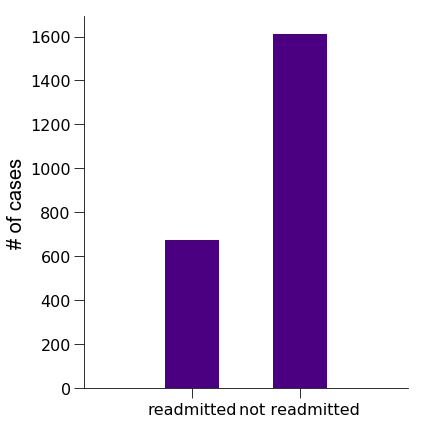

Proprotion readmitted: 0.2950


In [714]:
# Ok..we've processed the data..
# First, let's take a look to see the frequency of readmissions and no readmissions 
import matplotlib.pyplot as plt
import os
curr_dir = os.getcwd()
figFolder=os.path.join(curr_dir,'Figures')

idx_readmitted=cleaned_data.index[cleaned_data.readmitted==True]
idx_notreadmitted=cleaned_data.index[cleaned_data.readmitted==False]
sum_readmitted=cleaned_data.loc[idx_readmitted,'readmitted'].count()
sum_notreadmitted=cleaned_data.loc[idx_notreadmitted,'readmitted'].count()

plt.figure(figsize=(6,6))
plt.tight_layout
ax=plt.subplot()
plt.bar([0,1],[sum_readmitted,sum_notreadmitted],color='indigo',width=0.5)
figfont={'fontname':'Arial'}
plt.ylabel('# of cases',fontsize=20,**figfont)
plt.xticks([0,1],['readmitted','not readmitted'])
# #plt.axis('square')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlim([-1,2])
#ax.yaxis.set_major_formatter(PercentFormatter(xmax=1))
plt.tick_params(labelsize=14,length=10)
# Save the current figure
thisFig='Bias.pdf'
figname=os.path.join(figFolder,thisFig)
#plt.box(False)
plt.tick_params(labelsize=16,length=10)
plt.savefig(figname,transparent=True,pad_inches=1)


plt.show()
x=sum_readmitted/(sum_readmitted+sum_notreadmitted)
print('Proprotion readmitted: %.4f' %x)

In [690]:
# Let's also get some summary statistics of readmitted vs not readmitted
grouped_data=cleaned_data.groupby('readmitted')
grouped_data.describe()

num_lab_procedures                                               \
                        count       mean        std  min   25%   50%   75%   
readmitted                                                                   
False                  1611.0  37.707014  18.827159  1.0  24.0  40.0  51.0   
True                    674.0  40.663205  19.571659  1.0  30.0  42.0  54.0   

                  num_medications             ...    rowID          \
              max           count       mean  ...      75%     max   
readmitted                                    ...                    
False       103.0          1611.0  13.397890  ...   7379.0  9997.0   
True        106.0           674.0  13.718101  ...   7329.5  9983.0   

           time_in_hospital                                                
                      count      mean       std  min  25%  50%  75%   max  
readmitted                                                                 
False                1611.0  3.378026  2.407388  1.0  2.0  3.0  4.0  14.0  
True                  674.0  3.600890  2.502789  1.0  2.0  3.0  5.0  14.0  

[2 rows x 72 columns]

Ok... above visualisation shows that data is biased towards not readmitted

In [583]:
# Ok..now we have our data, let's do some prelim analysis
# Let's compare the group that was admitted vs the group that was not admitted
# See if they statistically differ for specific measurements

import numpy as np
import pandas as pd
import scipy
import statsmodels.api as stats
import matplotlib.pyplot as plt

# These are variables we will test for effects that are categorical
these_variables=['race','gender','age','admission_type_id',\
                'max_glu_serum','A1Cresult','change','diabetesMed','discharge_home']

chi2_pval=[None]*len(these_variables)

for counter, var in enumerate(these_variables):
    idx=cleaned_data.index[cleaned_data[var]!='NA']
    thisData=cleaned_data.loc[idx,[var,'readmitted']]
    
    # Print all the unique categorical values
    unique_var=thisData[var].unique()
    unique_var=np.sort(unique_var)
    print('\n Category: ',var, '\nUnique vals:',unique_var)
    
    # Ok, get the number of times each occurence happened
    readmitted=[None]*len(unique_var)
    not_readmitted=[None]*len(unique_var)
    for vv,uvar in enumerate(unique_var):
        # First count the number of readmitted cases for this specific group
#         idx1=thisData.index[thisData[var]==unique_var[vv]]
#         idx2=thisData.index[thisData.readmitted==True]
        idx1=thisData[var]==unique_var[vv]
        idx2=thisData.readmitted==True
        
        idx=idx1 & idx2
        readmitted[vv]=thisData.loc[idx,'readmitted'].count()
        # Now count the number of non-readmitted cases for this specific group
        #idx2=thisData.index[thisData.readmitted==False]
        idx2=thisData.readmitted==False
        idx=idx1 & idx2
        not_readmitted[vv]=thisData.loc[idx,'readmitted'].count()
        
    
    # Print frequencies and chi2 test results
    print('Readmitted freq: ', readmitted)
    print('Not readmitted freq: ', not_readmitted)
#     total_n=sum(readmitted)+sum(not_readmitted)
#     total_readmitted=sum(readmitted)
#     total_not_readmitted=sum(not_readmitted)
#     group_total=np.array(readmitted)+np.array(not_readmitted)
#     f_exp=total_readmitted*np.array(group_total)/total_n
#     dof=(len(f_exp)-1)*(2-1)
    contab=np.array([readmitted,not_readmitted])
    #chi2temp=scipy.stats.chisquare(f_obs=readmitted, f_exp=f_exp)
    chi2temp,ptemp,doftemp,exptemp=scipy.stats.chi2_contingency(contab)
    #scipy.stats.chi2_contingency(observed, correction=True, lambda_=None)[source]
    chi2_pval[counter]=ptemp
    print('Expected freq:',exptemp)
    print('pval=%2.4f' %chi2_pval[counter])

# Ok, in the special case of A1C result..paper found that just 
# taking measurements results in reduced readmission rates
# Let's test if true for our data too
idx=cleaned_data.index[cleaned_data['A1Cresult']!='NA']
thisData=cleaned_data.loc[idx,['A1Cresult','readmitted']]
    
# Ok we will split them into 2 groups, whether test was taken or not
readmitted=[None]*2
not_readmitted=[None]*2

# First do for when measurements were not taken
idx1=thisData['A1Cresult']=='None'
idx2=thisData.readmitted==True

idx=idx1 & idx2
idx=idx[idx==True]
readmitted[0]=thisData.loc[idx.index,'readmitted'].count()
idx2=thisData.readmitted==False
idx=idx1 & idx2
idx=idx[idx==True]
not_readmitted[0]=thisData.loc[idx.index,'readmitted'].count()

# And repeat for when test was not taken
idx1=thisData['A1Cresult']!='None'
idx2=thisData.readmitted==True

idx=idx1 & idx2
idx=idx[idx==True]
readmitted[1]=thisData.loc[idx.index,'readmitted'].count()
idx2=thisData.readmitted==False
idx=idx1 & idx2
idx=idx[idx==True]
not_readmitted[1]=thisData.loc[idx.index,'readmitted'].count()

# Print frequencies and chi2 test results
print('\nFor A1Cresult, if measured or not:')
print('Readmitted freq: ', readmitted)
print('Not readmitted freq: ', not_readmitted)

contab=np.array([readmitted,not_readmitted])
chi2temp,ptemp,doftemp,exptemp=scipy.stats.chi2_contingency(contab)
chi2_pval[counter]=ptemp
print('Expected freq:',exptemp)
print('pval=%2.4f' %ptemp)


 Category:  race 
Unique vals: ['AfricanAmerican' 'Asian' 'Caucasian' 'Hispanic' 'Other']
Readmitted freq:  [135, 4, 496, 18, 9]
Not readmitted freq:  [369, 13, 1104, 46, 21]
Expected freq: [[ 150.63115124    5.08081264  478.19413093   19.12776524    8.96613995]
 [ 353.36884876   11.91918736 1121.80586907   44.87223476   21.03386005]]
pval=0.4507

 Category:  gender 
Unique vals: ['Female' 'Male']
Readmitted freq:  [374, 300]
Not readmitted freq:  [876, 735]
Expected freq: [[368.70897155 305.29102845]
 [881.29102845 729.70897155]]
pval=0.6588

 Category:  age 
Unique vals: ['[0-10)' '[10-20)' '[20-30)' '[30-40)' '[40-50)' '[50-60)' '[60-70)'
 '[70-80)' '[80-90)' '[90-100)']
Readmitted freq:  [0, 8, 16, 34, 74, 127, 159, 162, 88, 6]
Not readmitted freq:  [8, 23, 39, 141, 238, 353, 338, 297, 144, 30]
Expected freq: [[  2.35973742   9.14398249  16.22319475  51.61925602  92.0297593
  141.58424508 146.59868709 135.38993435  68.43238512  10.61881838]
 [  5.64026258  21.85601751  38.77680525

The chi2 analysis above suggests that A1C measurement has no relationship with readmission..unlike what was found in paper

Age, admission type, whether medication was changed and whether they were discharged to home is related to readmission rates.

<Figure size 432x288 with 0 Axes>

/Applications/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


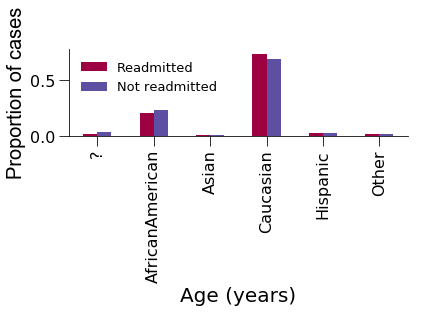

<Figure size 432x288 with 0 Axes>

/Applications/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


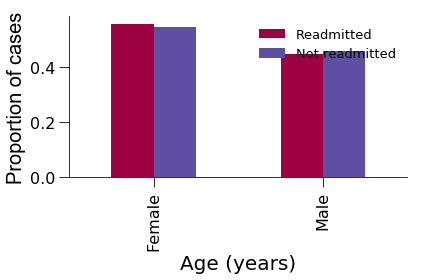

<Figure size 432x288 with 0 Axes>

/Applications/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


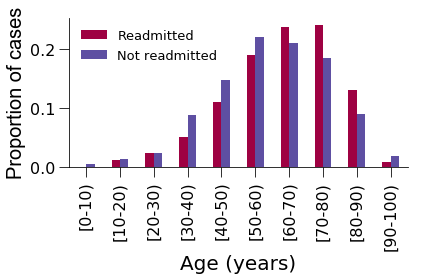

<Figure size 432x288 with 0 Axes>

/Applications/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


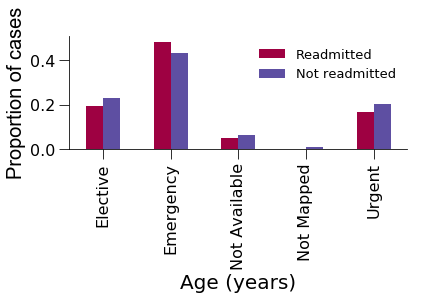

<Figure size 432x288 with 0 Axes>

/Applications/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


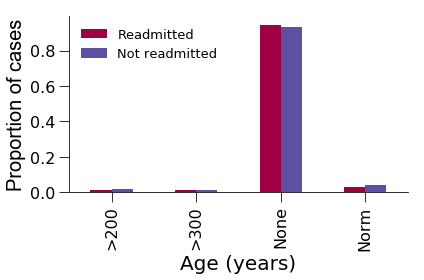

<Figure size 432x288 with 0 Axes>

/Applications/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


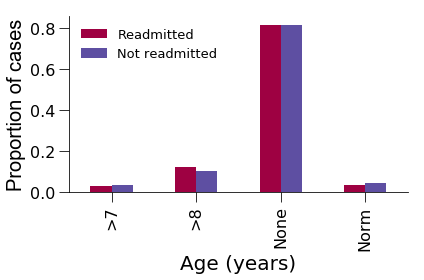

<Figure size 432x288 with 0 Axes>

/Applications/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


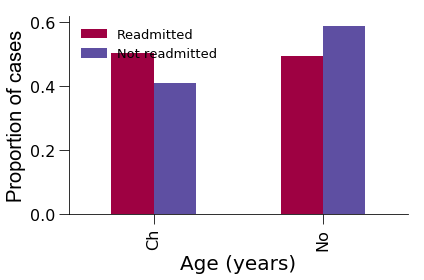

<Figure size 432x288 with 0 Axes>

/Applications/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


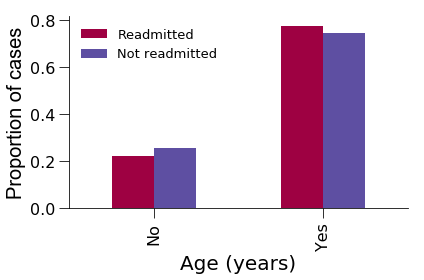

<Figure size 432x288 with 0 Axes>

/Applications/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


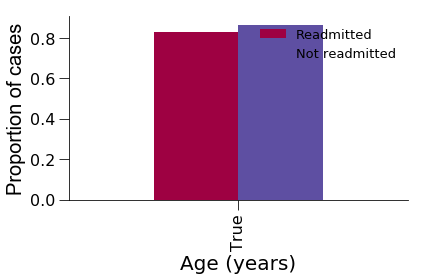

In [713]:
# Let's visualise the categorical dimensions and how they affect readmission
from matplotlib import cm
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

cmap = cm.get_cmap('Spectral')

these_variables=['race','gender','age','admission_type_id',\
                'max_glu_serum','A1Cresult','change','diabetesMed','discharge_home']

for counter, var in enumerate(these_variables):
    idx=cleaned_data.index[cleaned_data[var]!='NA']
    thisData=cleaned_data.loc[idx,[var,'readmitted']]
    tempval1=cleaned_data.loc[idx,'readmitted']
    norm_notreadmitted=sum(tempval1==False)
    norm_readmitted=sum(tempval1==True)
    
    tempval=pd.crosstab(thisData[var],thisData.readmitted)
    tempval[0]=tempval[0]/norm_notreadmitted
    tempval[1]=tempval[1]/norm_readmitted
    tempval=tempval.loc[:,[1,0]]
    #tempval[0:1]=tempval[1,0]
    
    plt.figure()
    #ax=plt.subplot()
    ax=tempval.plot(kind='bar', stacked=False,colormap=cmap)
    figfont={'fontname':'Arial'}
    plt.ylabel('Proportion of cases',fontsize=20,**figfont)
    # #plt.axis('square')
    #ax.yaxis.set_major_formatter(PercentFormatter(xmax=1))
    plt.legend(['Readmitted','Not readmitted'],fontsize=13,frameon=False)
    plt.tick_params(labelsize=16,length=10)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    if var=='age':
        # Save the current figure
        thisFig='AgeDependence.pdf'
        figname=os.path.join(figFolder,thisFig)
        plt.savefig(figname,transparent=True,pad_inches=1)
        plt.xlabel('Age (years)',fontsize=20)
    
    
    plt.show()

In [584]:
# Ok , we investigated effects of categorical data
# What about quantitative data?

import numpy as np
import pandas as pd
import scipy
import statsmodels.api as stats
import matplotlib.pyplot as plt

# These are variables we will test for effects that are categorical
these_variables=['num_lab_procedures','num_procedures','num_medications','number_outpatient',\
                'number_emergency','time_in_hospital']

ttest2_pval=[None]*len(these_variables)

for counter, var in enumerate(these_variables):
    print('\n Quantity: ',var)
    
    # Ok, get the relevant values for readmitted and not readmitted
    idx=cleaned_data.readmitted==True
    readmitted=cleaned_data.loc[idx,var]
    idx=cleaned_data.readmitted==False
    idx=idx[idx==True]
    not_readmitted=cleaned_data.loc[idx.index,var]
    
    # Do ttest
    tstattemp,ptemp=scipy.stats.ttest_ind(readmitted,not_readmitted,nan_policy='omit')
    ttest2_pval[counter]=ptemp
    #scipy.stats.ttest_ind(a, b, axis=0, equal_var=True, nan_policy='propagate')[source]¶
    print('pval=%2.4f' %ttest2_pval[counter])
    
    


 Quantity:  num_lab_procedures
pval=0.0007

 Quantity:  num_procedures
pval=0.0668

 Quantity:  num_medications
pval=0.3704

 Quantity:  number_outpatient
pval=0.3102

 Quantity:  number_emergency
pval=0.0186

 Quantity:  time_in_hospital
pval=0.0462


The above analyses suggest that # of lab procedures, # emergency visits and # procedures (reaching significance), time in hospital is related to readmission rates

<Figure size 432x288 with 0 Axes>

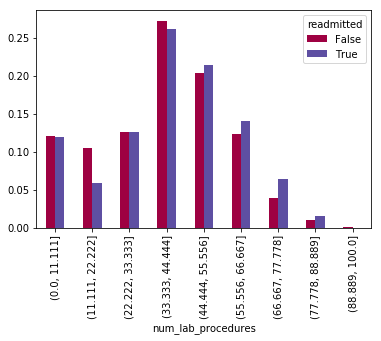

<Figure size 432x288 with 0 Axes>

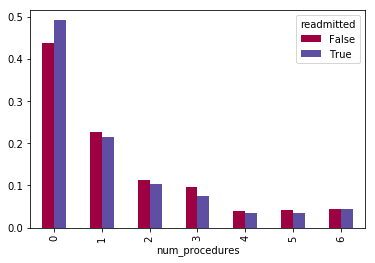

<Figure size 432x288 with 0 Axes>

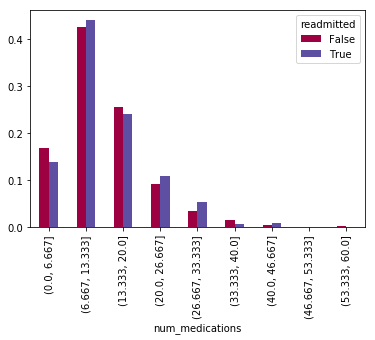

<Figure size 432x288 with 0 Axes>

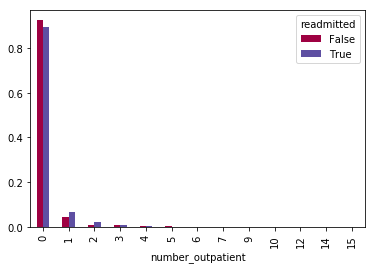

<Figure size 432x288 with 0 Axes>

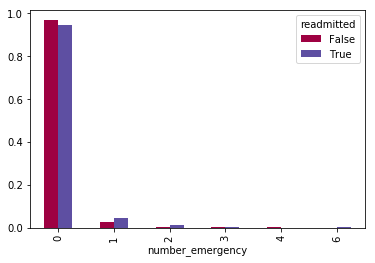

<Figure size 432x288 with 0 Axes>

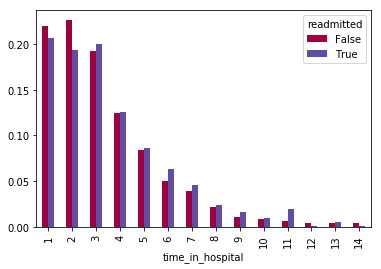

In [644]:
# Do another bar plot for the quantitative variables
these_variables=['num_lab_procedures','num_procedures','num_medications','number_outpatient',\
                'number_emergency','time_in_hospital']

for counter, var in enumerate(these_variables):
    #idx=cleaned_data.index[cleaned_data[var]!='NA']
    thisData=cleaned_data.loc[:,[var,'readmitted']]
    tempval1=cleaned_data.loc[:,'readmitted']
    norm_notreadmitted=sum(tempval1==False)
    norm_readmitted=sum(tempval1==True)
    
    
    if (var=='num_lab_procedures'): 
        #maxval=max(thisData[var])
        bins=np.linspace(0,100,10) 
        # Have a cross tab of specific bins
        temp_df=pd.cut(thisData[var],bins=bins)
        tempval=pd.crosstab(temp_df,thisData.readmitted)
    elif (var=='num_medications'):
        bins=np.linspace(0,60,10) 
        # Have a cross tab of specific bins
        temp_df=pd.cut(thisData[var],bins=bins)
        tempval=pd.crosstab(temp_df,thisData.readmitted)
    else:
        tempval=pd.crosstab(thisData[var],thisData.readmitted)
        
    tempval[0]=tempval[0]/norm_notreadmitted
    tempval[1]=tempval[1]/norm_readmitted
    
    plt.figure()
    tempval.plot(kind='bar', stacked=False,colormap=cmap)
    plt.show()

In [416]:
cleaned_data.columns

Index(['rowID', 'race', 'gender', 'age', 'weight', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'payer_code', 'medical_specialty', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide.metformin', 'glipizide.metformin',
       'glimepiride.pioglitazone', 'metformin.rosiglitazone',
       'metformin.pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'diag_1_desc', 'diag_2_desc', 'diag_3_desc'],
      dtype='object')